In [43]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from copy import deepcopy
from astropy.convolution import convolve
from skimage.measure import block_reduce

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import psf

# Generate images with various PSFs

In [44]:
lens = SampleStrongLens()

num_pix = 45
side = 4.95
band = 'F184'

## Grab default substructure

In [45]:
# add CDM subhalos; NB same subhalo population for all
# lens.add_subhalos(util.unpickle(os.path.join(pickle_dir, 'cdm_subhalos_for_sample')))

## generate arrays

In [46]:
lens_1 = deepcopy(lens)
lens_3 = deepcopy(lens)
lens_5 = deepcopy(lens)
lens_7 = deepcopy(lens)
lens_9 = deepcopy(lens)

array_1 = lens_1.get_array(band=band, num_pix=num_pix, side=side)
array_3 = lens_3.get_array(band=band, num_pix=num_pix * 3, side=side)
array_5 = lens_5.get_array(band=band, num_pix=num_pix * 5, side=side)
array_7 = lens_7.get_array(band=band, num_pix=num_pix * 7, side=side)
array_9 = lens_9.get_array(band=band, num_pix=num_pix * 9, side=side)

## Band

In [47]:
detector = 1
detector_position = (2048, 2048)

kernel_f106 = psf.get_psf_kernel('F106', detector, detector_position, oversample=5, fov_arcsec=side)
kernel_f129 = psf.get_psf_kernel('F129', detector, detector_position, oversample=5, fov_arcsec=side)
kernel_f158 = psf.get_psf_kernel('F158', detector, detector_position, oversample=5, fov_arcsec=side)
kernel_f184 = psf.get_psf_kernel('F184', detector, detector_position, oversample=5, fov_arcsec=side)

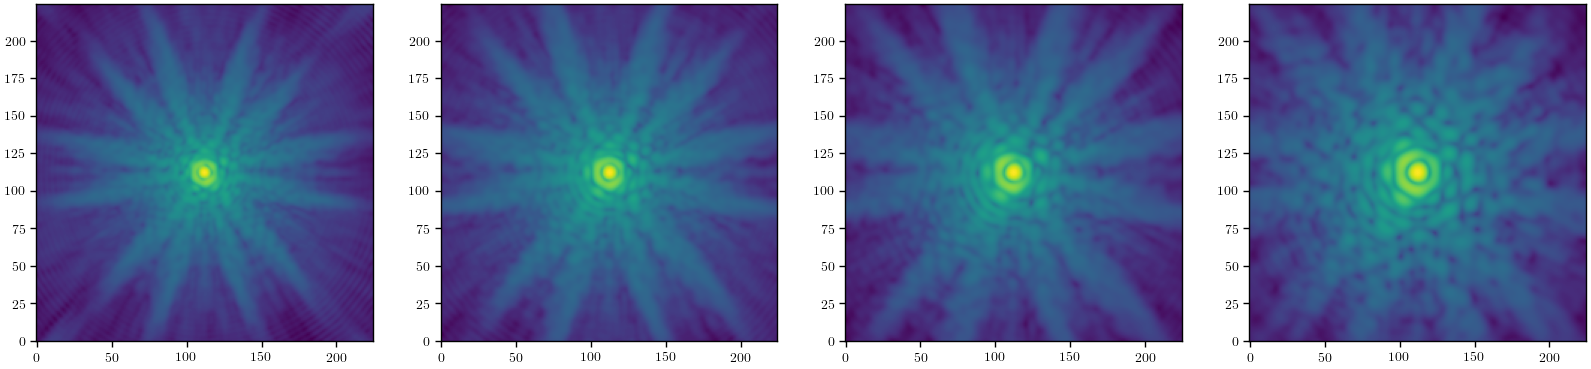

In [48]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(np.log10(kernel_f106))
ax[1].imshow(np.log10(kernel_f129))
ax[2].imshow(np.log10(kernel_f158))
ax[3].imshow(np.log10(kernel_f184))
# for a in ax:
#     a.axis('off')
plt.show()

In [49]:
band_f106 = convolve(array_5, kernel_f106)
band_f129 = convolve(array_5, kernel_f129)
band_f158 = convolve(array_5, kernel_f158)
band_f184 = convolve(array_5, kernel_f184)

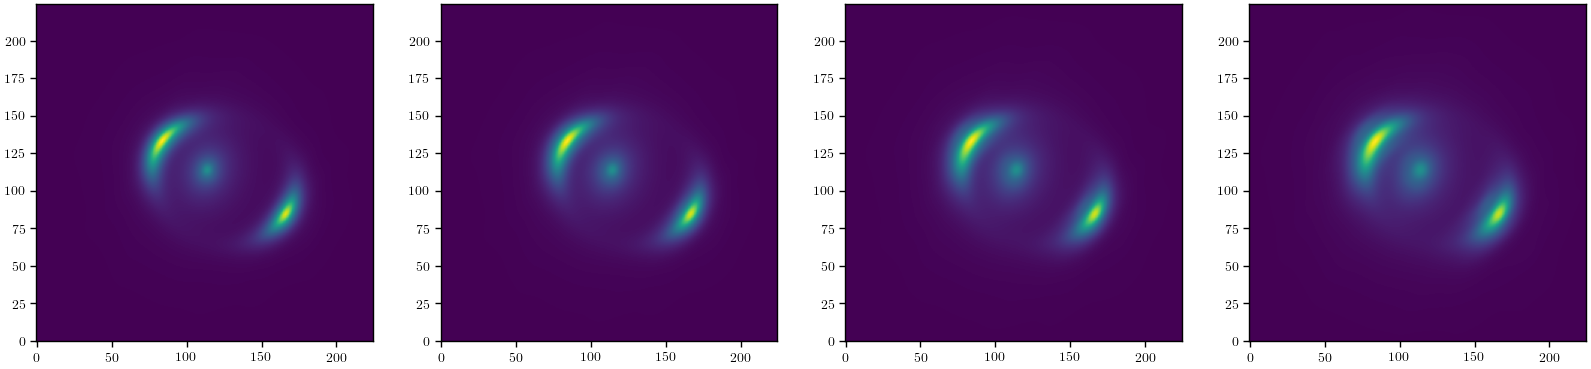

In [50]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(band_f106)
ax[1].imshow(band_f129)
ax[2].imshow(band_f158)
ax[3].imshow(band_f184)
# for a in ax:
#     a.axis('off')
plt.show()

In [51]:
# downsample to 45, 45
band_f106 = block_reduce(band_f106, (5, 5), np.mean)
band_f129 = block_reduce(band_f129, (5, 5), np.mean)
band_f158 = block_reduce(band_f158, (5, 5), np.mean)
band_f184 = block_reduce(band_f184, (5, 5), np.mean)

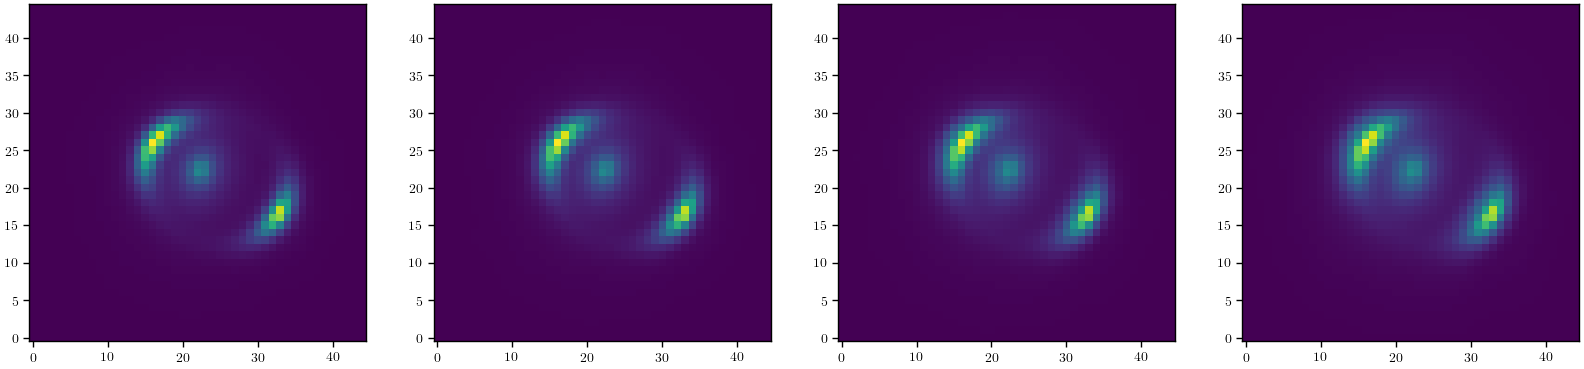

In [52]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(band_f106)
ax[1].imshow(band_f129)
ax[2].imshow(band_f158)
ax[3].imshow(band_f184)
# for a in ax:
#     a.axis('off')
plt.show()

## Oversampling

In [53]:
detector = 1
detector_position = (2048, 2048)

kernel_1 = psf.get_psf_kernel(band, detector, detector_position, oversample=1, fov_arcsec=side)
kernel_3 = psf.get_psf_kernel(band, detector, detector_position, oversample=3, fov_arcsec=side)
kernel_5 = psf.get_psf_kernel(band, detector, detector_position, oversample=5, fov_arcsec=side)
kernel_7 = psf.get_psf_kernel(band, detector, detector_position, oversample=7, fov_arcsec=side)
kernel_9 = psf.get_psf_kernel(band, detector, detector_position, oversample=9, fov_arcsec=side)

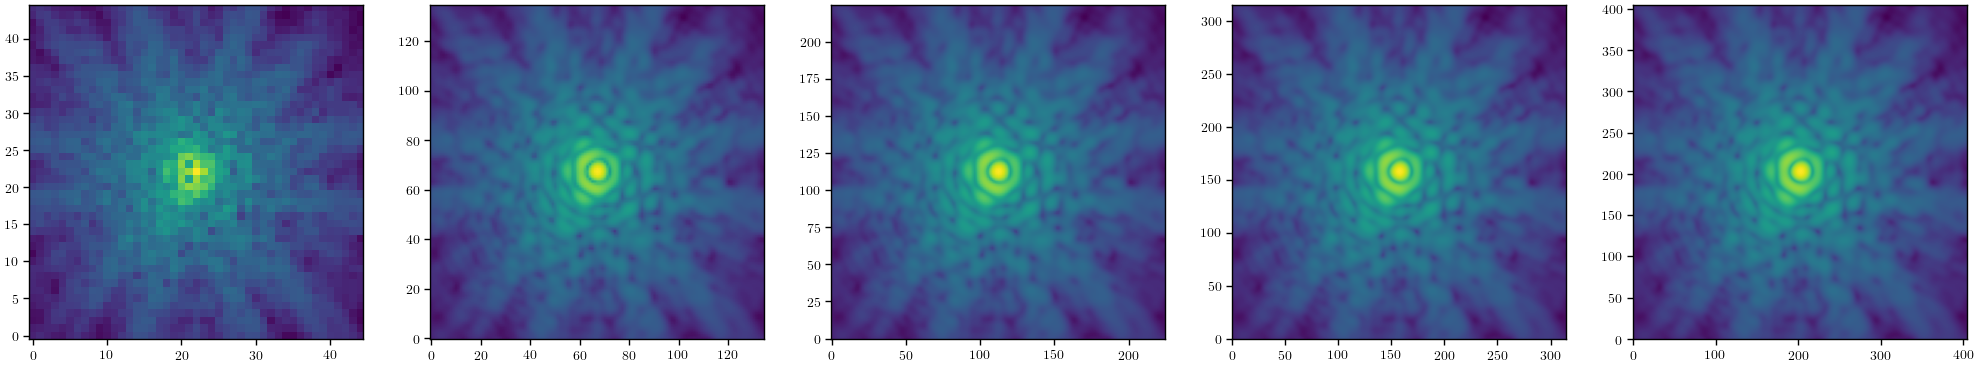

In [54]:
f, ax = plt.subplots(1, 5, figsize=(25, 5))
ax[0].imshow(np.log10(kernel_1))
ax[1].imshow(np.log10(kernel_3))
ax[2].imshow(np.log10(kernel_5))
ax[3].imshow(np.log10(kernel_7))
ax[4].imshow(np.log10(kernel_9))
# for a in ax:
#     a.axis('off')
plt.show()

In [55]:
oversample_1 = convolve(array_1, kernel_1)
oversample_3 = convolve(array_3, kernel_3)
oversample_5 = convolve(array_5, kernel_5)
oversample_7 = convolve(array_7, kernel_7)
oversample_9 = convolve(array_9, kernel_9)

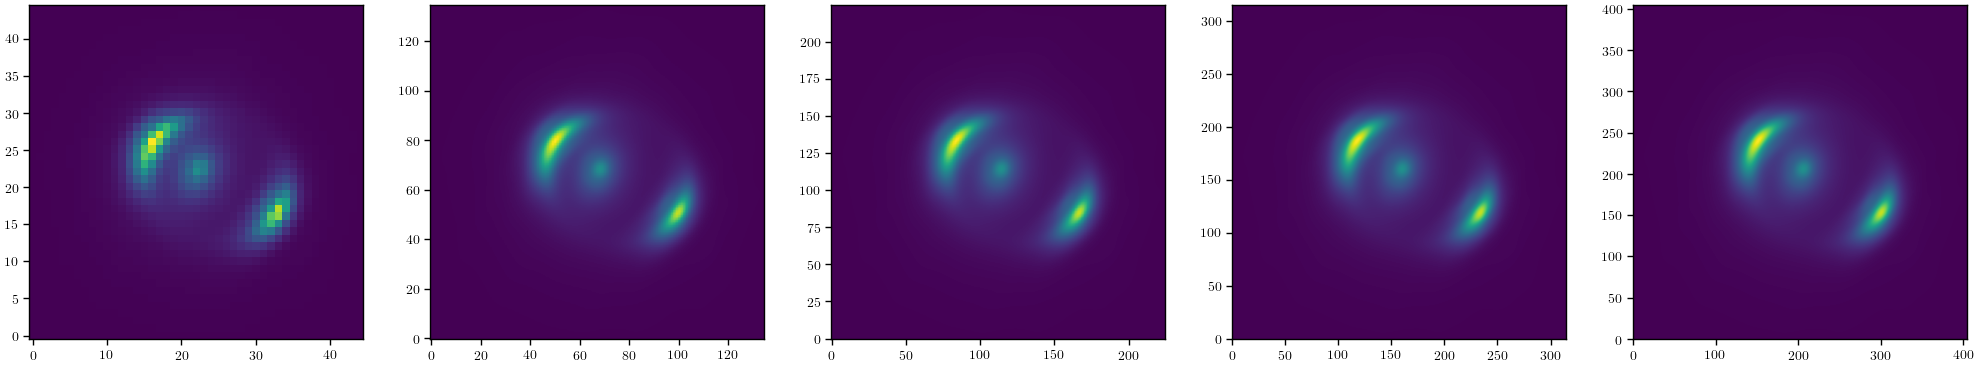

In [56]:
f, ax = plt.subplots(1, 5, figsize=(25, 5))
ax[0].imshow(oversample_1)
ax[1].imshow(oversample_3)
ax[2].imshow(oversample_5)
ax[3].imshow(oversample_7)
ax[4].imshow(oversample_9)
# for a in ax:
#     a.axis('off')
plt.show()

In [57]:
# downsample to 45, 45
oversample_3 = block_reduce(oversample_3, (3, 3), np.mean)
oversample_5 = block_reduce(oversample_5, (5, 5), np.mean)
oversample_7 = block_reduce(oversample_7, (7, 7), np.mean)
oversample_9 = block_reduce(oversample_9, (9, 9), np.mean)

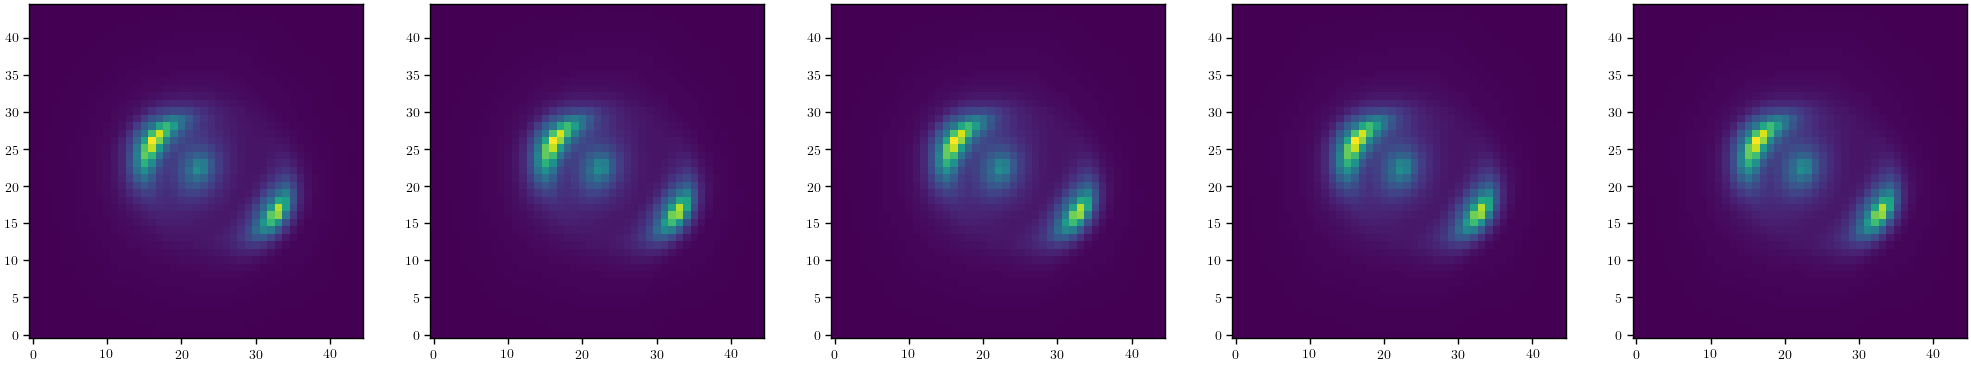

In [58]:
f, ax = plt.subplots(1, 5, figsize=(25, 5))
ax[0].imshow(oversample_1)
ax[1].imshow(oversample_3)
ax[2].imshow(oversample_5)
ax[3].imshow(oversample_7)
ax[4].imshow(oversample_9)
# for a in ax:
#     a.axis('off')
plt.show()

In [59]:
# calculate residuals
residual_1 = oversample_9 - oversample_1
residual_3 = oversample_9 - oversample_3
residual_5 = oversample_9 - oversample_5
residual_7 = oversample_9 - oversample_7

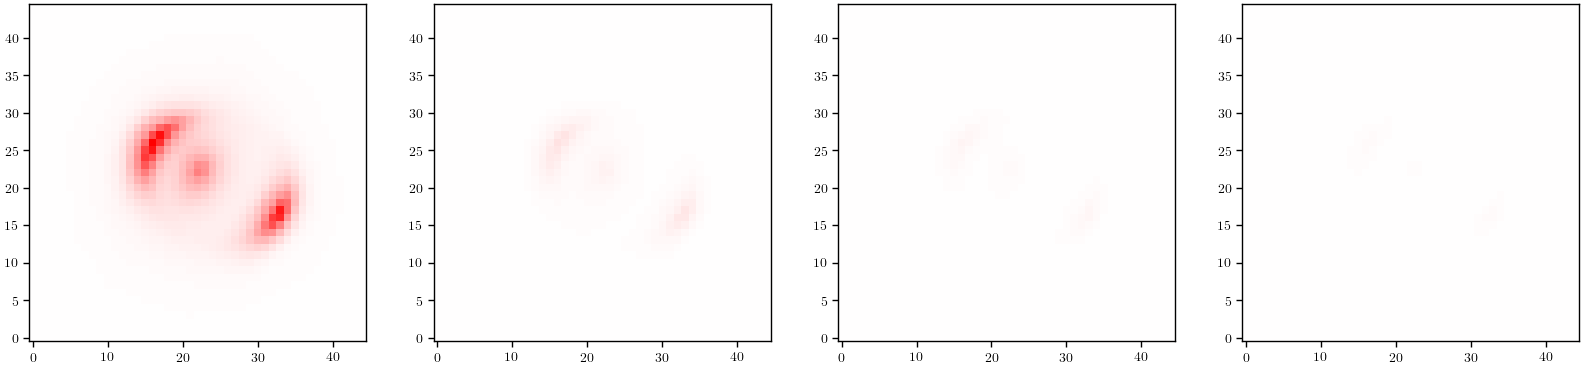

In [60]:
v = plot_util.get_v([residual_1, residual_3, residual_5, residual_7])

f, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(oversample_1, vmin=-v, vmax=v, cmap='bwr')
ax[1].imshow(oversample_3, vmin=-v, vmax=v, cmap='bwr')
ax[2].imshow(oversample_5, vmin=-v, vmax=v, cmap='bwr')
ax[3].imshow(oversample_7, vmin=-v, vmax=v, cmap='bwr')
# for a in ax:
#     a.axis('off')
plt.show()

# Plot

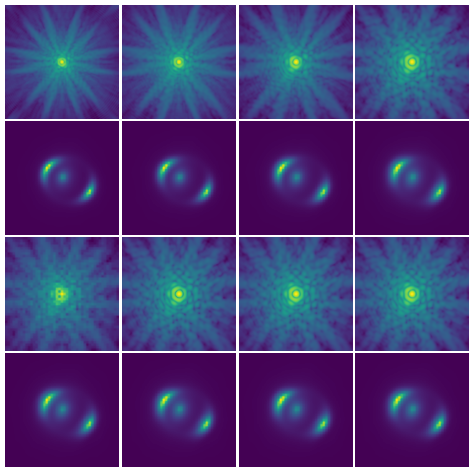

In [61]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(6, 6), gridspec_kw={'hspace': 0.02, 'wspace': 0.02})  # 

ax[0][0].imshow(np.log10(kernel_f106))
ax[0][1].imshow(np.log10(kernel_f129))
ax[0][2].imshow(np.log10(kernel_f158))
ax[0][3].imshow(np.log10(kernel_f184))

ax[1][0].imshow(band_f106)
ax[1][1].imshow(band_f129)
ax[1][2].imshow(band_f158)
ax[1][3].imshow(band_f184)

ax[2][0].imshow(np.log10(kernel_1))
ax[2][1].imshow(np.log10(kernel_3))
ax[2][2].imshow(np.log10(kernel_5))
ax[2][3].imshow(np.log10(kernel_7))

ax[3][0].imshow(oversample_1)
ax[3][1].imshow(oversample_3)
ax[3][2].imshow(oversample_5)
ax[3][3].imshow(oversample_7)

for a in ax.flatten():
    a.axis('off')

# cbar_residuals = fig.colorbar(axis_2, ax=ax[1], ticks=[-1, 0, 1])
# cbar_residuals.set_label('counts/sec', rotation=90)

plt.savefig(os.path.join(figure_dir, 'psf_compare.png'))
plt.show()